In [ ]:
import sys
print(sys.version)

In [ ]:
#
# Load and extract the 327k bucket names downloaded from Grayhat Warfare
#
# The provided S3 names contain complete AWS domain information as well, which will be one of the following formats:
# 1) [bucket_name].s3.amazonaws.com
# 2) [bucket_name].s3-[aws_region].amazonaws.com
# 3) [bucket_name].s3.[aws_region].amazonaws.com
# 
#
import json, re

def extract_bucket_name(bucket_url):
    # Define regex pattern to match and capture the bucket name
    pattern = r"^(.+)?\.s3(?:[\.-])(.+)?amazonaws.com(?:\.[a-z]{2})?$"
    
    # Search for the pattern in the given URL
    match = re.match(pattern, bucket_url)
    
    # Return the bucket name if found, otherwise None
    return match.group(1) if match else None


with open('buckets.json', 'r') as f:
    gh_data = json.load(f)

bucket_names = [x['bucket'] for x in gh_data]
bucket_names = [extract_bucket_name(x) for x in bucket_names]
bucket_names = [b for b in bucket_names if b is not None]

# Save point, all bucket names minus the AWS domains
with open('parsed_buckets.json', 'w') as f:
    json.dump(bucket_names, f, indent=2)

In [ ]:
#
# Modifying and (hopefully) simplifying our pipeline with Spacy.  We still need to tokenize as usual, let's 
# do that now.
#
import json

with open('parsed_buckets.json') as f:
    buckets = json.load(f)

# Start with a simple Regex based tokenizer for the light work.
custom_tokenizer = RegexpTokenizer(r'\d+|[a-zA-Z]+')
tokenized_buckets = []
for b in buckets:
   tokenized_buckets.append(custom_tokenizer.tokenize(b.lower()))

from wordsegment import load, segment
load()
results = []
for bucket in tokenized_buckets:
    current_tokens = []
    for b in bucket:
       current_tokens.extend(segment(b))
    results.append(current_tokens)

with open("tokenized_buckets.json", "w") as f:
    json.dump(results, f, indent=2)


In [ ]:
#
# 
# Set up the Spacy pipeline
#
import spacy
from spacy.tokens import Token, Span
from spacy.language import Language

# Load the spaCy pipeline
nlp = spacy.load("en_core_web_md")

# Add custom attributes
Token.set_extension("is_custom_tagged", default=False, force=True)
Token.set_extension("custom_tag", default=None, force=True)

# Define a custom tagging component
@Language.component("custom_tagger")
def custom_tagger(doc):
    custom_tags = {}
    with open('custom_tags.json', 'r') as f:
        custom_tag_src = json.load(f)
        for tag, words in custom_tag_src.items():
            for word in words:
                custom_tags[word] = tag

    for token in doc:
        if token.text in custom_tags:
            t = custom_tags[token.text]
            token._.is_custom_tagged = True
            token._.custom_tag = t
            token.ent_type_ = t
            token.tag_ = t
    return doc

# Add the custom tagger to the pipeline
nlp.add_pipe("custom_tagger", after="ner")
print("Pipeline Component Order:", nlp.pipe_names)

bucket_names = []
with open('tokenized_buckets.json', 'r') as f:
    tokenized_buckets = json.load(f)
    bucket_names.extend([" ".join(b) for b in tokenized_buckets])

with open('tagged_buckets.json', 'w') as f:
    all_tags = []
    for bucket_name in bucket_names:
        doc = nlp(bucket_name)
        # print("Token Details:")
        tags = []
        for token in doc:
            txt = token.lemma_
            tag = token.tag_ if token.ent_type_ == "" else token.ent_type_
            tags.append((txt, tag))
        all_tags.append(tags)

    json.dump(all_tags, f, indent=2)

Pipeline Component Order: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'custom_tagger']


In [ ]:
#
# Let's get some statistics on the n-gram tokens
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

n_grams = {}

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

for bucket_tags in tagged_buckets:
    tag_len = len(bucket_tags)
    count = n_grams.get(tag_len, 0)
    count = count + 1
    n_grams[tag_len] = count


#
# To prevent the long-tail from clogging up our view, filter out any n-grams with
# less than 50 count (out of 327,000)
#
filtered_n_grams = {key: value for key, value in n_grams.items() if value >= 50}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(filtered_n_grams.items()), columns=["Key", "Value"])

# Sort the DataFrame by "Key" to match ascending key order
df = df.sort_values(by="Key")


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to normalize all values in the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Plot the frequency with Seaborn
sns.set_style("dark")
sns.barplot(x="Key", y="Value", data=df)
plt.title("Frequency of n-gram bucket names")
plt.xlabel("n-gram")
plt.ylabel("frequency")
plt.show()




In [36]:
import json

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

#
# Given a list of tokenized and tagged buckets, return a map of transition counts between
# the tag types
#
# Keys are compund and of the form '<src>/<dst>'
#
def build_transition_counts(buckets) -> dict:
    transition_counts = {}

    ignored = 0
    for bucket in buckets:
        blen = len(bucket)
        counts_map = transition_counts.get(blen, {})
        if blen == 1:
            ignored = ignored +1
            continue # We can't operate on a unigram bucket name
        # Each bucket is a list(list(txt, tag)) , We only care about the tag and the following tag.
        src_tag = None
        for pair in bucket:
            tag = pair[1]
            if src_tag == None:
                # This is our first time through, save the tag and continue
                src_tag = tag
                continue
            else:
                # Mark the transition
                key = f"{src_tag}/{tag}"
                count = counts_map.get(key, 0)
                count = count + 1
                counts_map[key] = count
                src_tag = tag
        transition_counts[blen] = counts_map
    print(f"Ignored {ignored} unigram buckets")
    return transition_counts

counts = build_transition_counts(tagged_buckets)
for key, transition_map in counts.items():
    sorted_counts = {key: value for key, value in sorted(transition_map.items(), key=lambda item: item[1], reverse=True)}
    print(f"[{key}]: {sorted_counts}")


Ignored 5315 unigram buckets
[2]: {'NN/NN': 9254, 'PERSON/PERSON': 8495, 'NN/NNS': 4830, 'NNP/NNP': 3933, 'NNP/NN': 3769, 'ORG/ORG': 3545, 'JJ/NN': 3418, 'NNP/INFRA': 3057, 'NN/INFRA': 2408, 'PERSON/INFRA': 2003, 'NNP/NNS': 1996, 'ORG/INFRA': 1772, 'JJ/NNS': 1745, 'VB/NN': 1662, 'ORG/NN': 1302, 'INFRA/NN': 1209, 'ORG/NNP': 1200, 'ORG/NNS': 1165, 'NN/CARDINAL': 1150, 'NNP/CARDINAL': 862, 'JJ/INFRA': 837, 'NN/VBZ': 804, 'NN/WEB': 711, 'NNS/NN': 632, 'VB/INFRA': 622, 'NNP/WEB': 618, 'NNP/VBZ': 598, 'VB/NNS': 592, 'WEB/NN': 572, 'NNP/ORG': 562, 'NNS/VBP': 560, 'PERSON/NNP': 552, 'NNS/INFRA': 539, 'ORG/WEB': 514, 'DT/NN': 463, 'NNP/PERSON': 452, 'INFRA/PERSON': 446, 'GPE/NNP': 431, 'ORG/VBZ': 428, 'NNS/NNS': 417, 'INFRA/NNS': 402, 'NNP/PHASE': 386, 'IN/NN': 381, 'VBG/NN': 368, 'PERSON/NNS': 366, 'NNP/GPE': 364, 'CARDINAL/NN': 363, 'ORG/PHASE': 346, 'NN/VBP': 337, 'PHASE/NN': 323, 'NN/NNP': 323, 'NN/PHASE': 321, 'VB/PRP': 288, 'VBZ/NN': 282, 'VB/JJ': 278, 'NN/JJ': 278, 'INFRA/CARDINAL': 276,

In [ ]:
#
# Let's figure out how many unique tags we have here
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

# Map n-gram -> map<tag, count>
tag_map = {}

for bucket in tagged_buckets:
    ngram = len(bucket)
    tags = tag_map.get(ngram, {})

    for tag_tuple in bucket:
        tuple_name = tag_tuple[1]
        count = tags.get(tuple_name, 0)
        count += 1
        tags[tuple_name] = count
    tag_map[ngram] = tags

# We'll save our tag collection here for the next stage
tag_export = {}

for ngram, tag_counts in tag_map.items():
    top_tags = sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)[:20]

    tag_export[ngram] = top_tags

    df = pd.DataFrame(top_tags, columns=['Key', 'Value'])
    df['Scaled'] = df['Value'] / df['Value'].sum()

    # Sort the DataFrame by "Key" to match ascending key order
    # df = df.sort_values(by="Value")

    # Plot the frequency with Seaborn
    sns.set_style("dark")
    sns.barplot(x="Key", y="Scaled", data=df)
    plt.title(f"Tag Frequency for {ngram}-gram buckets (n={df['Value'].sum()})")
    plt.xlabel("Tag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

with open('ngram_tag_counts.json', 'w') as f:
    json.dump(tag_export, f, indent=2)

Ignored 5315 unigram buckets


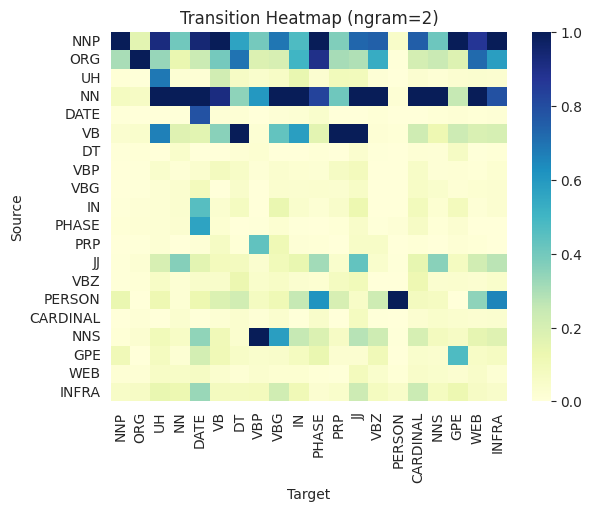

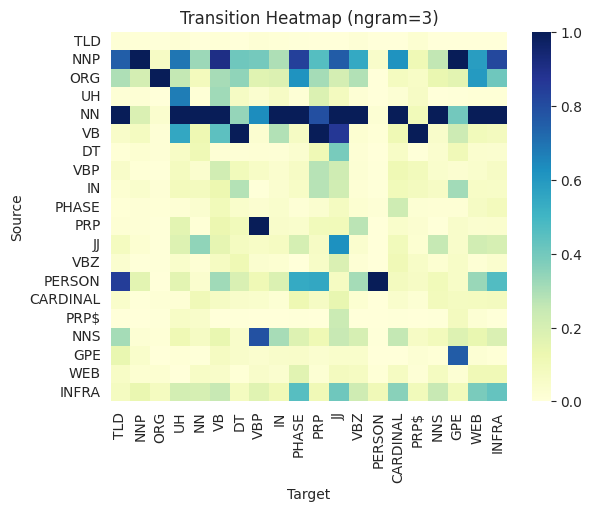

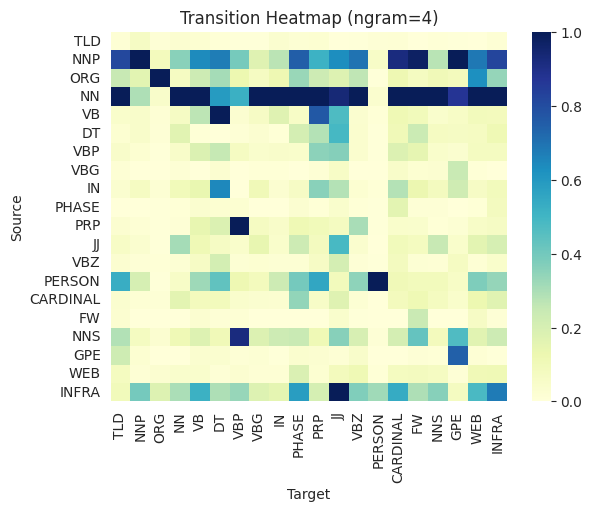

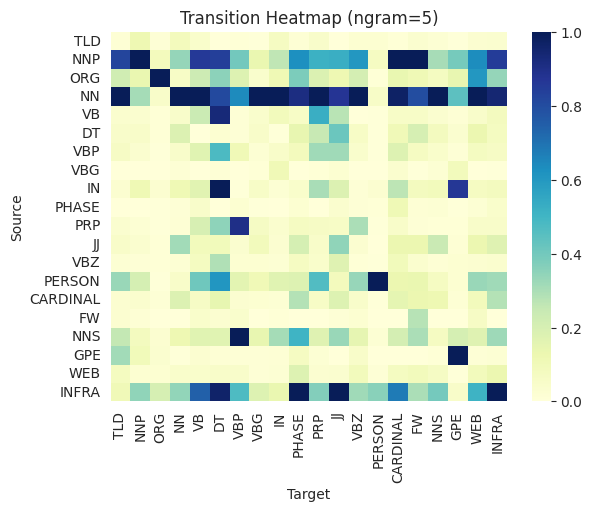

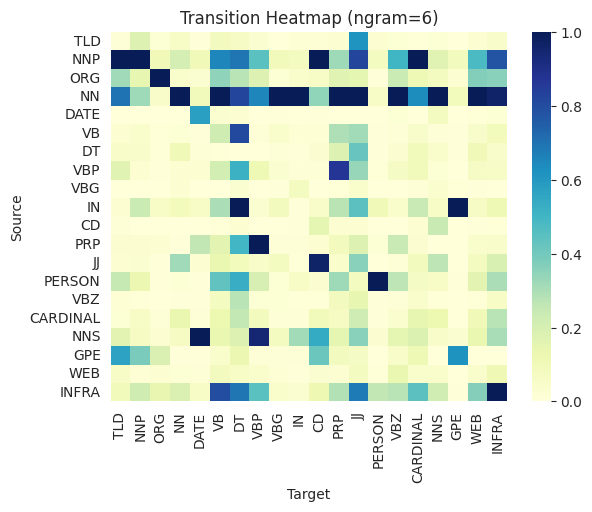

In [25]:
#
# Build the heatmap of transitions for the top tags 
# for {2-6}-gram buckets
#
import json
import pandas as pd
import numpy as np

with open('ngram_tag_counts.json', 'r') as f:
    ngram_tag_counts = json.load(f)

with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

#
# Given a list of tokenized and tagged buckets, return a map of transition counts between
# the tag types
#
# Keys are compund and of the form '<src>/<dst>'
#
def build_transition_counts(buckets) -> dict:
    transition_counts = {}

    ignored = 0
    for bucket in buckets:
        blen = len(bucket)
        counts_map = transition_counts.get(blen, {})
        if blen == 1:
            ignored = ignored +1
            continue # We can't operate on a unigram bucket name
        # Each bucket is a list(list(txt, tag)) , We only care about the tag and the following tag.
        src_tag = None
        for pair in bucket:
            tag = pair[1]
            if src_tag == None:
                # This is our first time through, save the tag and continue
                src_tag = tag
                continue
            else:
                # Mark the transition
                key = f"{src_tag}/{tag}"
                count = counts_map.get(key, 0)
                count = count + 1
                counts_map[key] = count
                src_tag = tag
        transition_counts[blen] = counts_map
    print(f"Ignored {ignored} unigram buckets")
    return transition_counts

counts = build_transition_counts(tagged_buckets)

#
# Before we build the heatmaps, let's export this to a useful format for our Markov Chain (to be used later).
# 
# We currently have: map[ngram, map[src/dest, counts]]
# We need: map[ngram, map[src, map[dst, count]]]
#
exported_transitions = {}
for ngram, transitions in counts.items():
    ngram_map = exported_transitions.get(ngram, {})
    for trans, count in transitions.items():
        (src, dst) = trans.split("/")
        src_map = ngram_map.get(src, {})
        src_map[dst] = count
        ngram_map[src] = src_map
    exported_transitions[ngram] = ngram_map
with open('transitions.json', 'w') as f:
    json.dump(exported_transitions, f, indent=2)

#
# At this point the transition counts are far too many to show in a heat map.  Filter this with
# the top tags. Filter our any transition that uses a tag not in the top list.  This is specific to the n-gram size.
#
frames = {}
for ngram, tags in counts.items():
    top_tags = set(k for k,_ in ngram_tag_counts[str(ngram)])
    size = min(20, len(top_tags))
    df = pd.DataFrame(np.zeros((size, size)), columns=list(top_tags), index=list(top_tags))
    for tag_pair in tags.items():
        (tag1, tag2) = tag_pair[0].split("/")
        if set(tag_pair[0].split("/")).issubset(top_tags):
            df.at[tag1, tag2] = tag_pair[1] 
    # print(df)
    frames[ngram] = df

import seaborn as sns
import matplotlib.pyplot as plt

for ngram in range(2,7):
    df = frames[ngram]
    normalized_df = (df - df.min()) / (df.max() - df.min())
    sns.heatmap(normalized_df, annot=False, cmap="YlGnBu")

    # Add labels and title
    plt.title(f"Transition Heatmap (ngram={ngram})")
    plt.xlabel("Target")
    plt.ylabel("Source")

    # Show the heatmap
    plt.show()

{2: {'PHASE': 922, 'NNS': 3567, 'PRP': 621, 'NN': 22769, 'ORG': 11806, 'INFRA': 3609, 'NNP': 19027, 'POS': 39, 'RB': 529, 'IN': 1119, 'VBN': 606, 'NNPS': 93, 'UH': 991, 'TLD': 200, 'VB': 5304, 'DEV': 303, 'WEB': 1445, 'PERSON': 13132, 'VBZ': 1123, 'VBP': 683, 'LS': 467, 'JJ': 7123, 'DT': 834, 'CARDINAL': 1026, 'VBG': 997, 'JJS': 100, 'DATE': 532, 'FW': 583, 'CD': 247, 'XX': 336, 'TIME': 47, 'QUANTITY': 35, 'PRODUCT': 248, 'LOC': 60, 'PRP$': 462, 'NORP': 468, 'NFP': 83, 'GPE': 1815, 'VBD': 533, 'MD': 106, 'RP': 50, 'LAW': 40, 'WDT': 9, 'CC': 80, 'JJR': 116, 'TO': 58, 'FAC': 56, '``': 11, 'RBR': 10, 'SYM': 4, 'WP': 14, 'ORDINAL': 45, 'WRB': 21, 'LANGUAGE': 8, 'RBS': 2, 'WORK_OF_ART': 19, 'PERCENT': 1, 'ADD': 25, 'MONEY': 5, 'EVENT': 9, ',': 2, 'AFX': 5, 'EX': 2, '-LRB-': 1, '.': 1}, 3: {'JJ': 7237, 'INFRA': 7141, 'POS': 307, 'VBN': 442, 'NNP': 17371, 'NN': 18698, 'TLD': 376, 'CARDINAL': 1433, 'VBP': 1117, 'TO': 115, 'PHASE': 1766, 'TIME': 45, 'VB': 6788, 'XX': 694, 'NNS': 2754, 'PERSON':

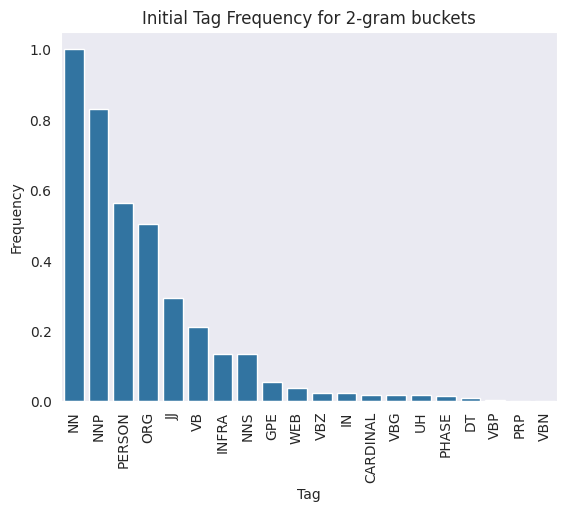

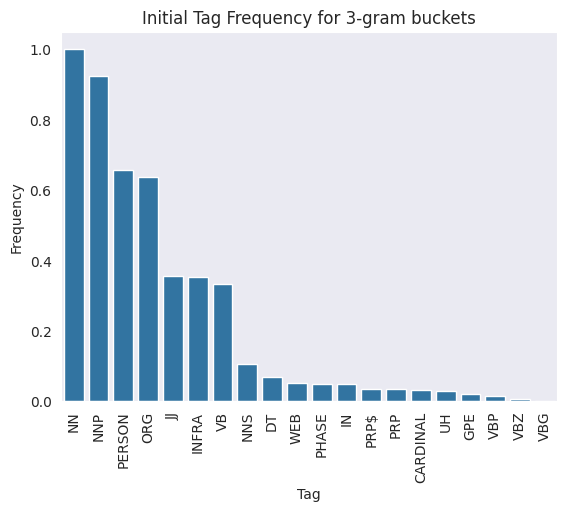

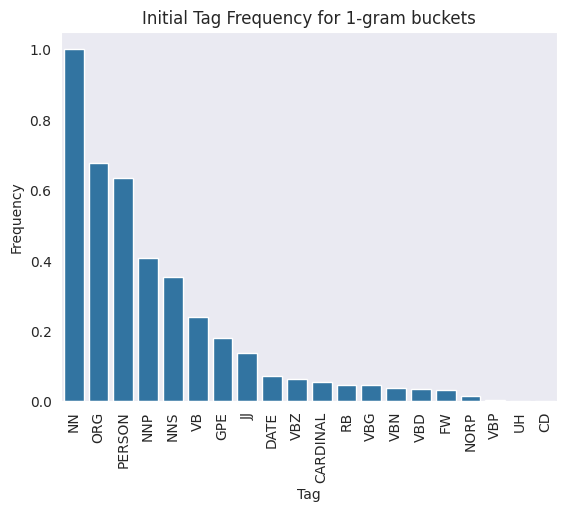

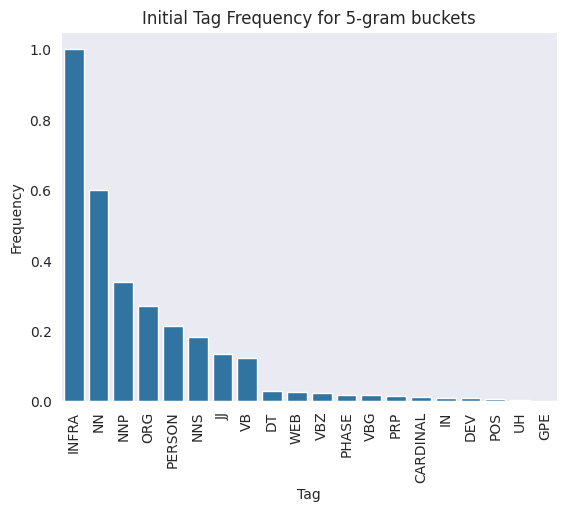

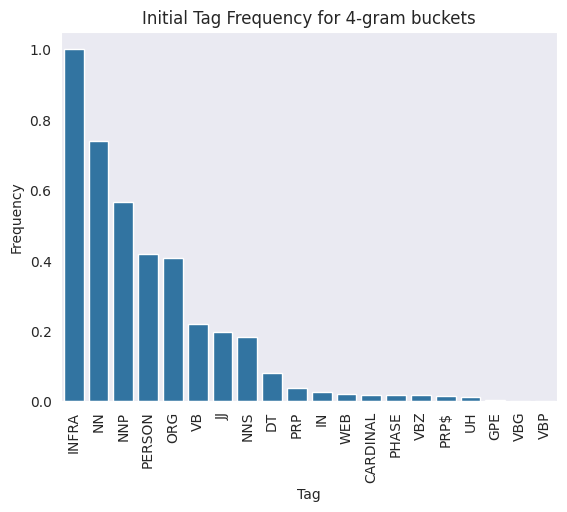

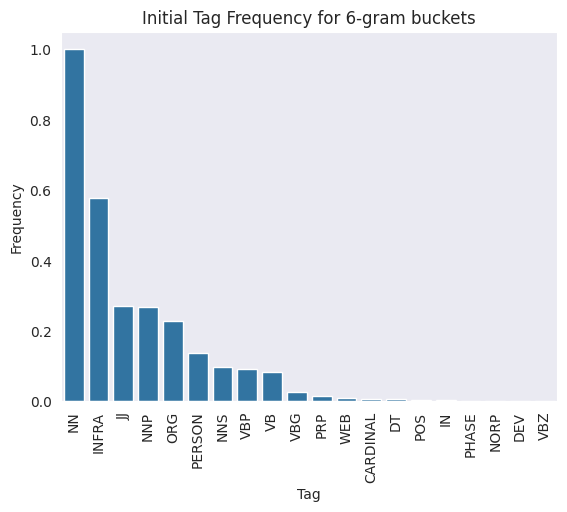

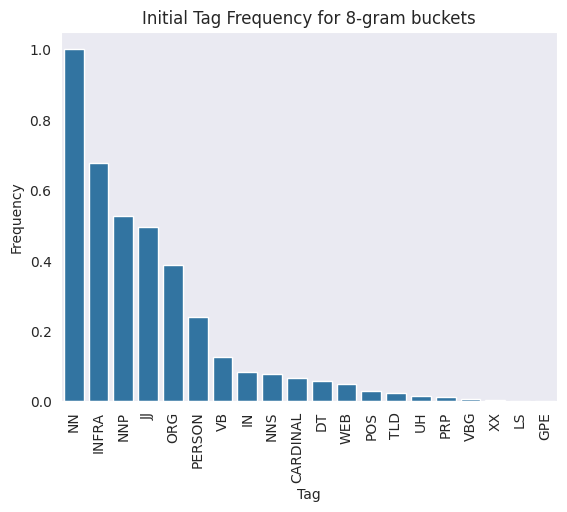

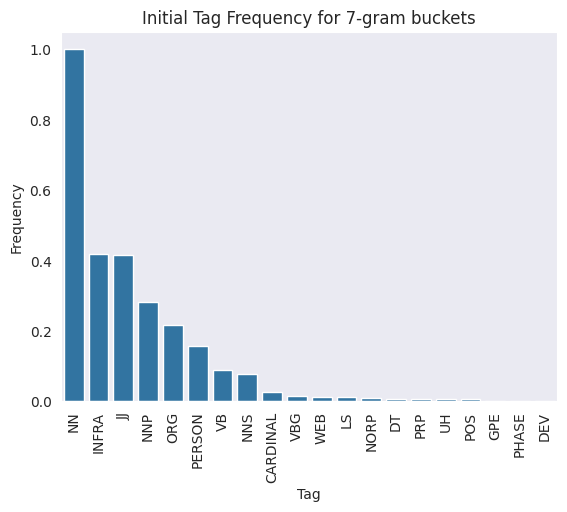

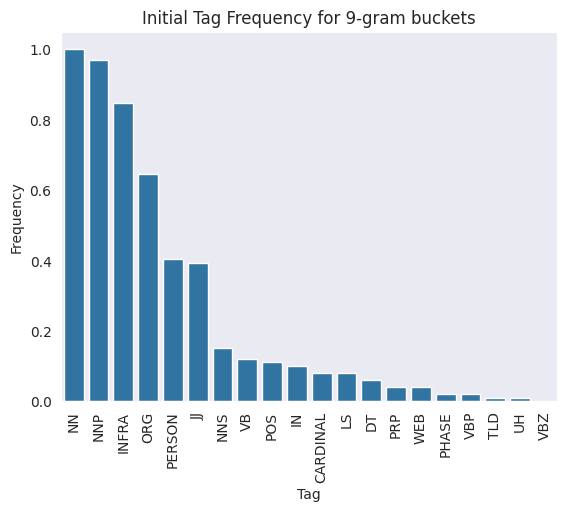

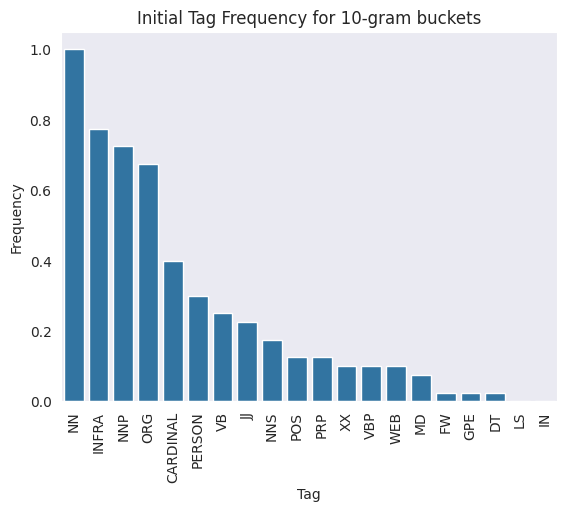

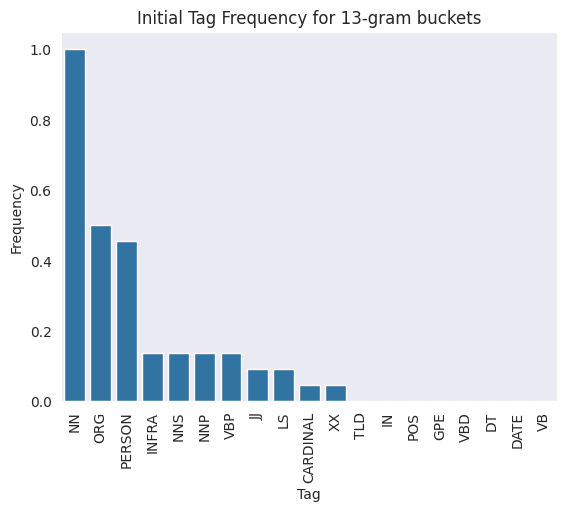

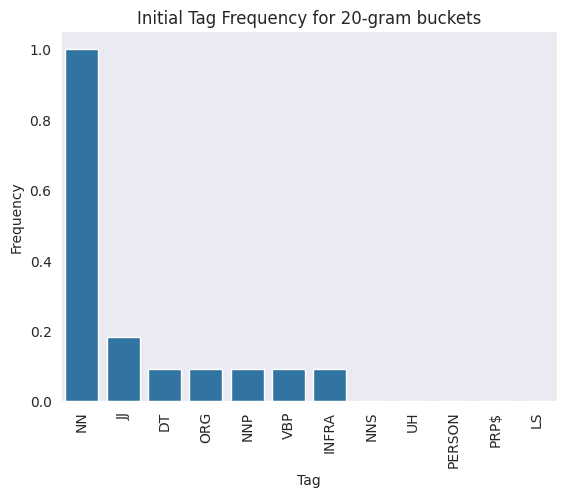

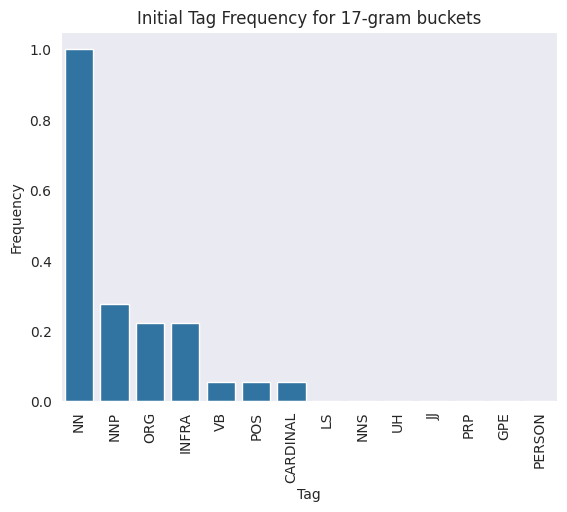

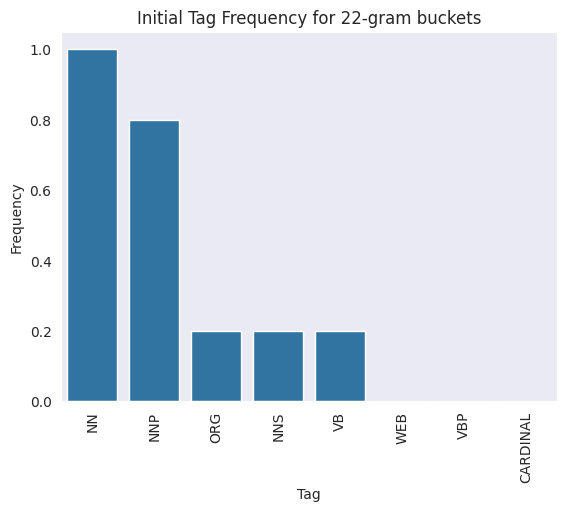

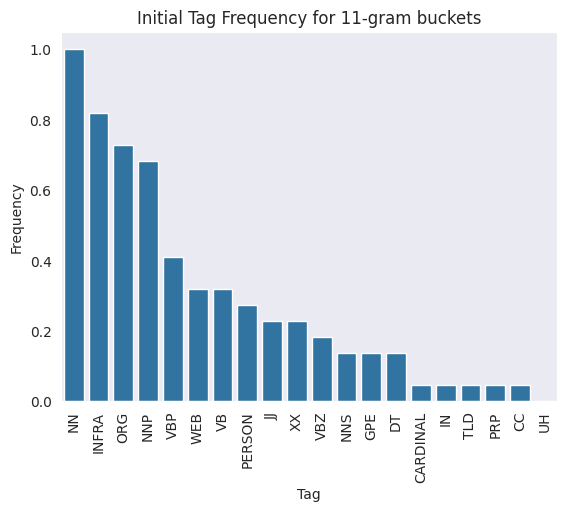

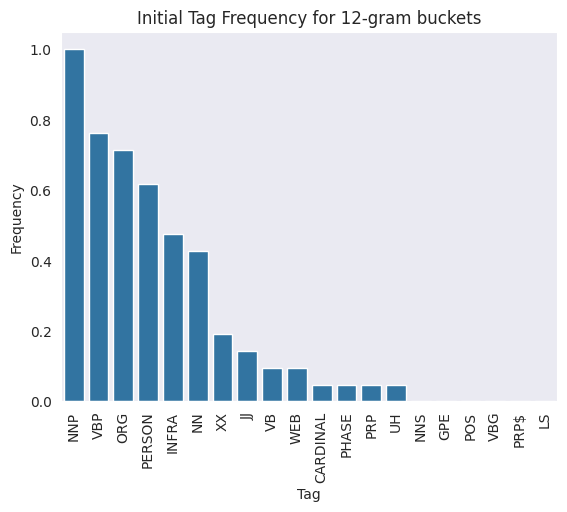

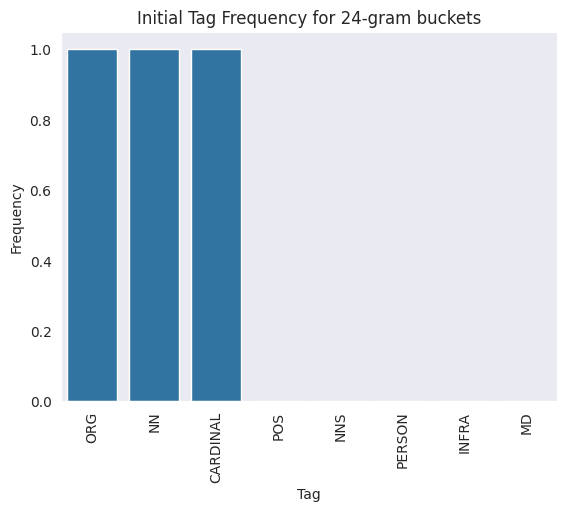

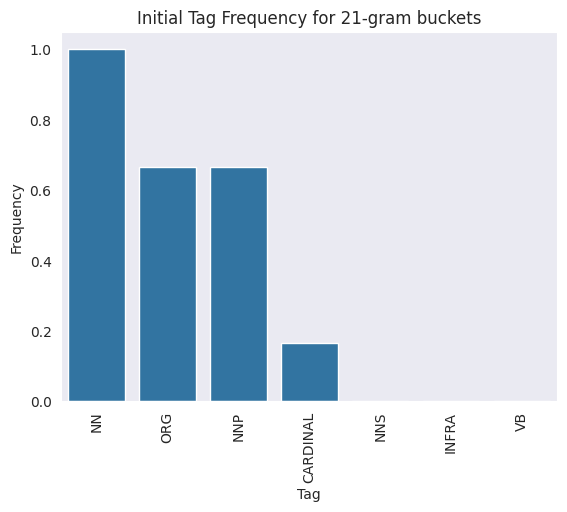

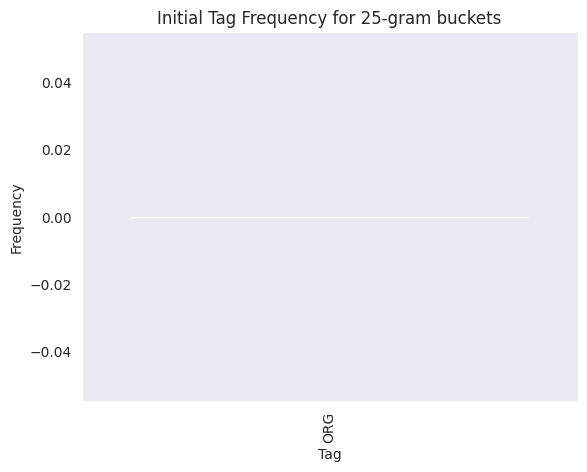

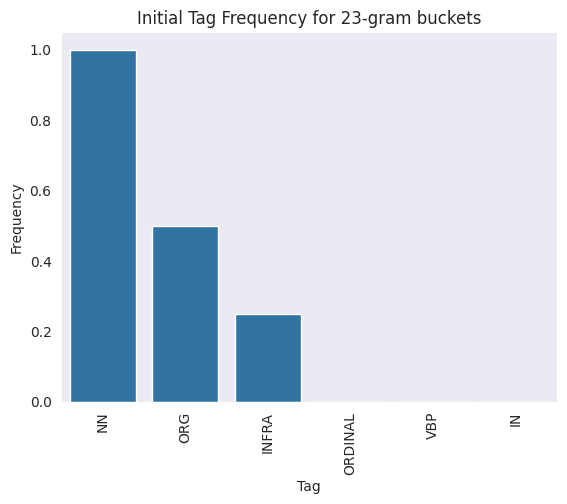

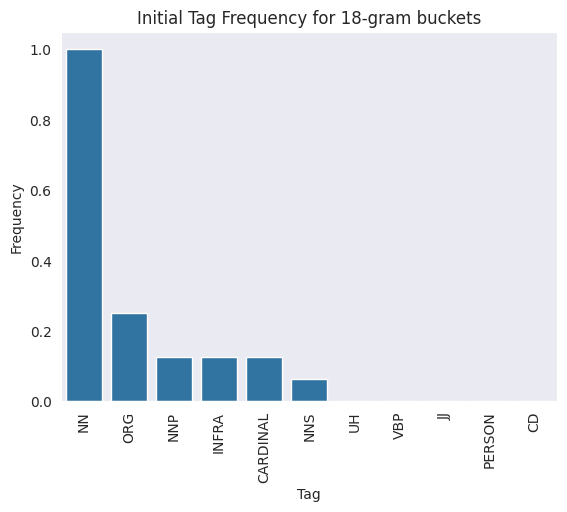

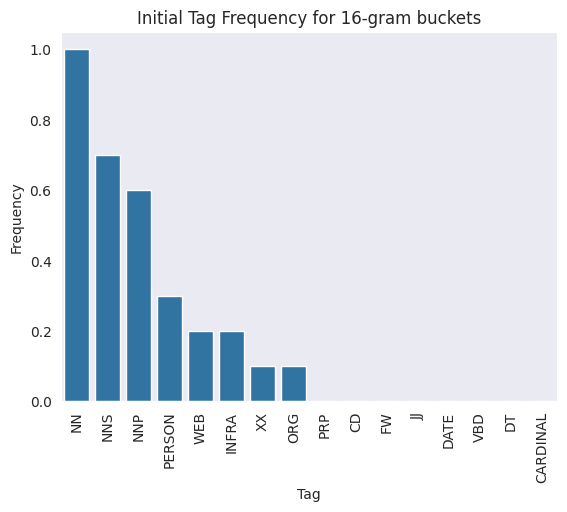

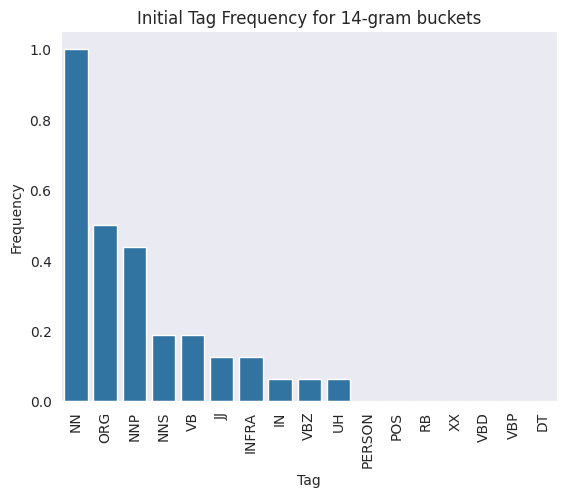

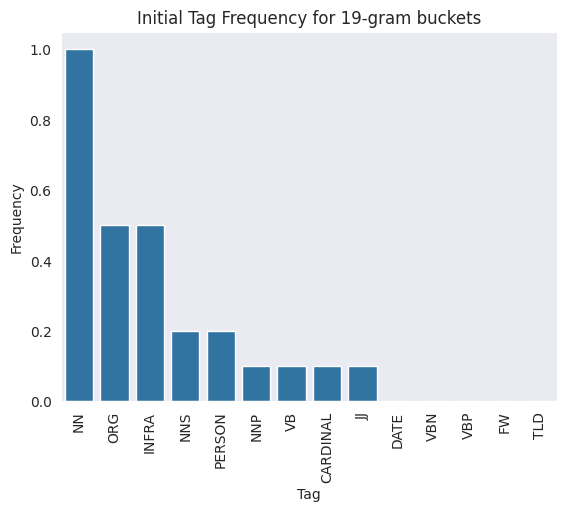

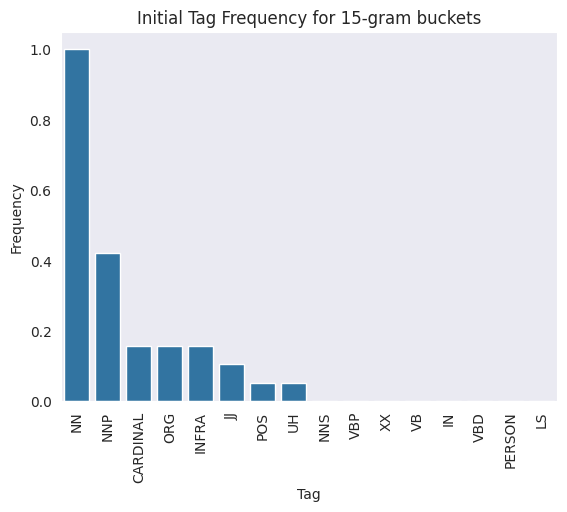

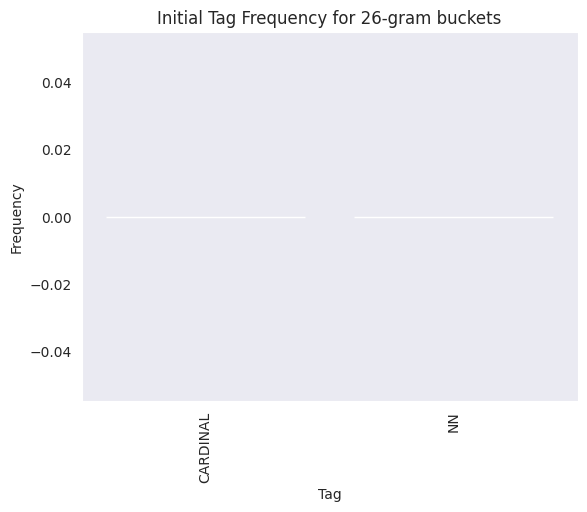

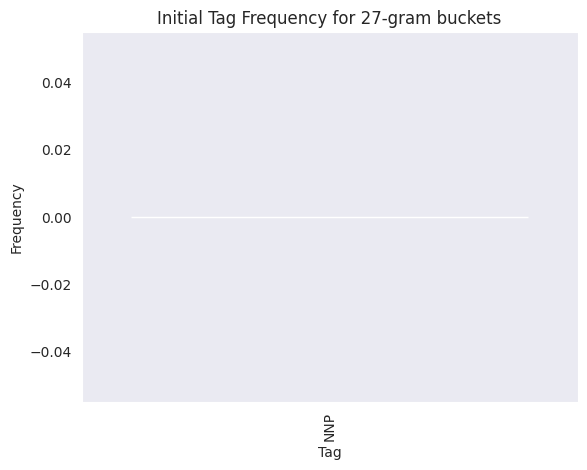

In [20]:
#
# Let's figure out initial state distributions for each ngram
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

initial_states_map = {}  # map[ngram, map[initial_state, count]]

with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

for bucket in tagged_buckets:
    ngram = len(bucket)
    tag = bucket[0][1]
    states = initial_states_map.get(ngram, {})
    count = states.get(tag, 0)
    count += 1
    states[tag] = count
    initial_states_map[ngram] = states

print(initial_states_map)
with open('initial_states.json', 'w') as f:
    json.dump(initial_states_map, f, indent=2)
    

for ngram, tags in initial_states_map.items():

    #
    # To prevent the long-tail from clogging up our view, use the top tags only
    #
    top_tags = sorted(tags.items(), key=lambda item: item[1], reverse=True)[:20]
    # filtered_n_grams = {key: value for key, value in initial_states_map.items() if value >= 50}

    # Convert dictionary to DataFrame
    df = pd.DataFrame(top_tags, columns=["Key", "Value"])

    # Sort the DataFrame by "Key" to match ascending key order
    df = df.sort_values(by="Value", ascending=False)
    scaler = MinMaxScaler()
    df['Normalized'] = scaler.fit_transform(df[['Value']])

    # Plot the frequency with Seaborn
    sns.set_style("dark")
    sns.barplot(x="Key", y="Normalized", data=df)
    plt.title(f"Initial Tag Frequency for {ngram}-gram buckets")
    plt.xlabel("Tag")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
import markov
import json

#
# Let's generate some transition chains using our Markov Model
#
with open('transitions.json', 'r') as f:
    transitions = json.load(f)

with open('initial_states.json', 'r') as f:
    initial_states = json.load(f)

for ngram, transition_map in transitions.items():
    mc = markov.MarkovChain(initial_states[ngram], transitions[ngram], iteration_count=int(ngram)-1)
    for i in range(5):
        print(f"ngram={ngram} tag_chain={mc.run()}")




ngram=2 state=['NNP', 'VBZ']
ngram=2 state=['VBD', 'INFRA']
ngram=2 state=['NN', 'NN']
ngram=2 state=['DATE', 'VBP']
ngram=2 state=['NNP', 'NNP']
ngram=3 state=['RP', 'NNP', 'NNP']
ngram=3 state=['NN', 'PHASE', 'INFRA']
ngram=3 state=['INFRA', 'INFRA', 'NNS']
ngram=3 state=['PRP', 'VBP', 'NNP']
ngram=3 state=['INFRA', 'PHASE', 'WEB']
ngram=5 state=['ORG', 'TLD', 'TLD', 'IN', 'INFRA']
ngram=5 state=['NN', 'GPE', 'TLD', 'NN', 'NN']
ngram=5 state=['JJ', 'NN', 'CARDINAL', 'NN', 'TLD']
ngram=5 state=['DATE', 'PRP', 'VBP', 'TLD', 'NNP']
ngram=5 state=['INFRA', 'NN', 'IN', 'IN', 'GPE']
ngram=4 state=['NNP', 'NNP', 'NNS', 'JJ']
ngram=4 state=['NN', 'RB', 'IN', 'NN']
ngram=4 state=['WEB', 'VBD', 'JJ', 'NNS']
ngram=4 state=['DATE', 'NN', 'DT', 'INFRA']
ngram=4 state=['PERSON', 'PERSON', 'TLD', 'NNP']
ngram=6 state=['INFRA', 'TLD', 'NNP', 'NN', 'NN', 'VB']
ngram=6 state=['NNP', 'NN', 'NN', 'IN', 'GPE', 'GPE']
ngram=6 state=['NNS', 'DT', 'NNP', 'INFRA', 'NNS', 'DATE']
ngram=6 state=['NN', 'NN', 'V